# Representing a double exponential convolution as an ODE
[Song et al. (2021)](https://www.sciencedirect.com/science/article/pii/S0165027021001084) in the NAOMi simulator, convolve the intracellular calcium trace with a double exponential kernel to capture variable rise and decay times in the fluorescence signal.

Here's an example of what that looks like:

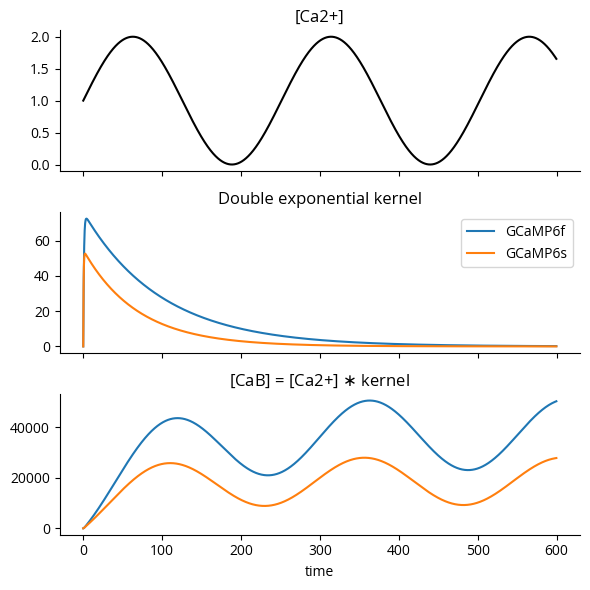

In [24]:
import matplotlib.pyplot as plt
import numpy as np


def doub_exp(t, tau_on=1, tau_off=100, A=1):
    return A * (1 - np.exp(-t / tau_on)) * np.exp(-t / tau_off)


t = np.arange(0, 600, 0.2)

h6f = doub_exp(t, 0.85, 98.6, 76.1)
h6s = doub_exp(t, 0.45, 68.5, 54.7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
c = np.sin(t / 40) + 1
ax1.plot(t, c, label="Ca2+", c="k")
ax1.set(title="[Ca2+]")

ax2.plot(t, h6f, label="GCaMP6f")
ax2.plot(t, h6s, label="GCaMP6s")
ax2.set(title="Double exponential kernel")
ax2.legend()

ax3.plot(t, np.convolve(c, h6f)[: len(t)], label="GCaMP6f")
ax3.plot(t, np.convolve(c, h6s)[: len(t)], label="GCaMP6s")
ax3.set(title="[CaB] = [Ca2+] $\\ast$ kernel", xlabel="time")

fig.tight_layout()

$\def\lr#1{\left(#1\right)}$
$\def\inv#1{\frac{1}{#1}}$
$\def\Ton{T_\text{on}}$
$\def\Toff{T_\text{off}}$




To simplify simulation (to not have to keep a buffer of past calcium values), we can represent this convolution as an ODE.
Let $c(t)$ and $b(t)$ be the free and bound calcium concentrations and $h(t)$ be the kernel function.

$$ h(t) = u(t) A \lr{1 - e^{-t/\tau_{\text{on}}}} e^{-t/\tau_\text{off}} $$
$$ b(t) = c(t) \ast h(t) $$

where $u(t)$ is the unit step function, multiplied to ensure the kernel is causal.
We can represent the convolution as multiplication in the Laplace domain.

$$ B(s) = C(s) H(s) $$



By expanding out $h(t)$, we get functions that can easily be transformed into the Laplace domain.
Let $T_\text{on} = \inv{\tau_\text{on}}$ and $T_\text{off} = \inv{\tau_\text{off}}$ to simplify notation.

$$
\begin{aligned}
h(t) &= A u(t) \lr{1 - e^{-\Ton t}} e^{-\Toff t} \\
  &= Au(t) e^{-\Toff t} - Au(t) e^{-(\Ton + \Toff) t} \\
H(s) &= A\lr{\inv{s + \Toff} - \inv{s + \Ton + \Toff}} \\
B(s) &= A\lr{\inv{s + \Toff} - \inv{s + \Ton + \Toff}}C(s) \\
\end{aligned}
$$



Now we get a common denominator and rearrange:

$$
\begin{gathered}
B(s) = A\lr{\frac{s + \Ton + \Toff + s + \Toff}{(s+\Toff)(s+\Ton+\Toff)}}C(s) \\
B(s) = A\lr{\frac{2s + 2\Toff + \Ton}{s^2 + (2\Toff+\Ton)s + \Toff^2+\Ton\Toff}}C(s) \\
\lr{s^2 + (2\Toff+\Ton)s + \Toff^2+\Ton\Toff}B(s) = A\lr{2s + 2\Toff + \Ton}C(s) \\
\end{gathered}
$$



We'll have to use the $s^2$ and $s$ terms to convert to a second-order ODE, using the fact that the Laplace transform of $f''(t)$ and $f'(t)$  are $s^2F(s) - sf(0^-) - f(0^-)$ and $sF(s) - f(0^-)$, respectively.

$\def\gathered#1{\begin{gathered}#1\end{gathered}}$
$\def\aligned#1{\begin{aligned}#1\end{aligned}}$
$\def\lrg#1{\lr{\begin{gathered}#1\end{gathered}}}$

$$
\begin{gathered}
\lr{\begin{gathered}
      s^2 \\ 
      + (2\Toff+\Ton)s \\ 
      + \lr{\Toff^2+\Ton\Toff}
    \end{gathered}}B(s)
  = A\lr{\begin{gathered}
           2s \\ 
           + \lr{2\Toff + \Ton}
         \end{gathered}}C(s) \\
\lr{\begin{gathered}
      s^2 \\ 
      + (2\Toff+\Ton)s \\ 
      + \lr{\Toff^2+\Ton\Toff}
    \end{gathered}}B(s) 
  - \gathered{sb(0^-)\\ b'(0^-)\\ (2\Toff+\Ton)b(0^-)\\ 2Ac(0^-)}
  = A\lr{\begin{gathered}
           2s \\ 
           + \lr{2\Toff + \Ton}
         \end{gathered}}C(s)
    - \gathered{ sb(0^-)\\  b'(0^-)\\ (2\Toff+\Ton)b(0^-)\\ 2Ac(0^-)} \\
\gathered{
      b''(t) \\ 
      + (2\Toff+\Ton)b'(t) \\ 
      + \lr{\Toff^2+\Ton\Toff}b(t) \\
      - 2Ac(0^-)\delta(t)
  }
  = \gathered{
           2Ac'(t) \\ 
           + A\lr{2\Toff + \Ton}c(t)
         }
    - \gathered{ b(0^-)(\delta'(t) + \delta(0))\\  b'(0^-)\delta(t) \\ (2\Toff+\Ton)b(0^-)\delta(t)} \\
\gathered{
      b''(t) \\ 
      + (2\Toff+\Ton)b'(t) \\ 
      + \lr{\Toff^2+\Ton\Toff}b(t) \\
      - 2Ac(0^-)\delta(t)
  }
  = \aligned{
        &2Ac'(t) \\ 
        &+ A\lr{2\Toff + \Ton}c(t) \\
        &- (b'(0) + b(0)\lr{2\Toff+\Ton})\delta(t) \\
        &- b(0)\delta'(t) \\
        &- b(0)\delta(0)
    }
\end{gathered}
$$


Let's prepare for simulating as a system of first-order ODEs by referring to $b'$ as $\beta$.

$$
\begin{gathered}
\gathered{
      \beta'(t) \\ 
      + (2\Toff+\Ton)\beta(t) \\ 
      + \lr{\Toff^2+\Ton\Toff}b(t) \\
      - 2Ac(0^-)\delta(t)
  }
  = \aligned{
        &2Ac'(t) \\ 
        &+ A\lr{2\Toff + \Ton}c(t) \\
        &- (\beta(0) + b(0)\lr{2\Toff+\Ton})\delta(t) \\
        &- b(0)\delta'(t) \\
        &- b(0)\delta(0)
    } \\
\aligned{

    b'(t) &= \beta(t) \\
    \beta'(t) &= \lr{\aligned{
        &2Ac'(t) \\ 
        &+ A\lr{2\Toff + \Ton}c(t) \\
        &- (\beta(0) + b(0)\lr{2\Toff+\Ton} - 2Ac(0))\delta(t) \\
        &- b(0)\delta'(t) \\
        &- b(0)\delta(0) \\
        &- (2\Toff+\Ton)\beta(t) \\ 
        &- \lr{\Toff^2+\Ton\Toff}b(t) \\
    }} \\
}
\end{gathered}
$$


The $\delta(t)$ term shouldn't be a problem&mdash;we can just set the initial condition.
The $\delta(0)$ term could be implemented by adding to the value of $\beta$ at every step.
But how to account for the $\delta'(t)$ term?

TODO: do rest of notebook with new solution

Now let's check our work with a symbolic solver:

In [148]:
sp.diff(sp.DiracDelta(t), t) + sp.DiracDelta(0)

DiracDelta(0) + DiracDelta(t, 1)

In [114]:
import sympy as sp
from sympy.abc import t, s

# Define symbols, functions
A, tau_on, tau_off = sp.symbols('A tau_on tau_off', real=True, positive=True)
c = sp.Function('c')(t)

h = A * (1 - sp.exp(-t / tau_on)) * sp.exp(-t / tau_off) * sp.Heaviside(t)
h

A*(1 - exp(-t/tau_on))*exp(-t/tau_off)*Heaviside(t)

In [117]:
tau = sp.Symbol("tau")
b = sp.integrate(c.subs(t, tau) * h.subs(t, t - tau), (tau, -sp.oo, t))
b

A*(Integral(c(tau)*exp(t/tau_on)*exp(tau/tau_off)*Heaviside(t - tau), (tau, -oo, t)) + Integral(-c(tau)*exp(tau/tau_off)*exp(tau/tau_on)*Heaviside(t - tau), (tau, -oo, t)))*exp(-t/tau_off)*exp(-t/tau_on)

In [55]:
dbdt = sp.diff(b, t)
dbdt

A*exp(-t/tau_off)*exp(-t/tau_on)*Integral(c(tau)*exp(t/tau_on)*exp(tau/tau_off)/tau_on, (tau, -oo, t)) - A*(Integral(c(tau)*exp(t/tau_on)*exp(tau/tau_off), (tau, -oo, t)) + Integral(-c(tau)*exp(tau/tau_off)*exp(tau/tau_on), (tau, -oo, t)))*exp(-t/tau_off)*exp(-t/tau_on)/tau_on - A*(Integral(c(tau)*exp(t/tau_on)*exp(tau/tau_off), (tau, -oo, t)) + Integral(-c(tau)*exp(tau/tau_off)*exp(tau/tau_on), (tau, -oo, t)))*exp(-t/tau_off)*exp(-t/tau_on)/tau_off

This is a bit hard to interpret, so let's see if it matches the solution we got by hand.

In [78]:
beta = sp.integrate(A*(2/tau_off + 1/tau_on)*c.subs(t, tau) - (1/tau_off**2 + 1/(tau_on*tau_off))*b.subs(t, tau), (tau, 0, t))
dbdt_hand = 2*A*c - (2/tau_off + 1/tau_on)*b + beta - b.subs(t, 0)*sp.DiracDelta(t)

From what I understand, that `equals()` method checks for equality numerically.


In [73]:
dbdt_hand.equals(dbdt, True)

That didn't work for some reason.
Let's try `simplify()` as [SymPy docs suggest](https://docs.sympy.org/latest/tutorials/intro-tutorial/gotchas.html#equals-signs).

In [79]:
sp.simplify(dbdt - dbdt_hand)

-2*A*c(t) - A*Integral(c(tau), (tau, 0, t))/tau_on + A*exp(-t/tau_off)*Integral(c(tau)*exp(tau/tau_off), (tau, -oo, t))/tau_on - A*exp(-t/tau_on - t/tau_off)*Integral(c(tau)*exp(tau/tau_off)*exp(tau/tau_on), (tau, -oo, t))/tau_off - 2*A*Integral(c(tau), (tau, 0, t))/tau_off + A*exp(-t/tau_off)*Integral(c(tau)*exp(tau/tau_off), (tau, -oo, t))/tau_off

Not quite right.
Let's check numerically ourselves by simulating the ODE.

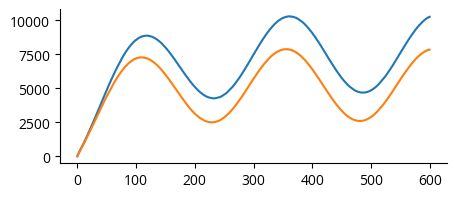

In [110]:
import numpy as np
from scipy.integrate import solve_ivp

t_eval = np.arange(0, 600, .2)

def c(t):
    # return 1/.2*(t<.2)
    return np.sin(t / 40) + 1

def dcdt(t):
    return 1/40*np.cos(t / 40)


def sol_b(tau_on, tau_off, A):
    def f(t, y):
        b, beta = y
        return [
            beta,
            (
                2*A*dcdt(t)
                + A * (2/tau_off + 1/tau_on) * c(t)
                # - (beta0 + b0*(2/tau_off + 1/tau_on) - 2*A*c0) * delta(t) 
            )
        ]

    sol = solve_ivp(f, [0, 600], [0, 0], t_eval=t_eval)
    return sol.t, sol.y[0]


fig, ax = plt.subplots(figsize=(5,2))
# plt.plot(c(np.arange(0, 600)))
ax.plot(*sol_b(.85, 98.6, 76.1))
ax.plot(*sol_b(.45, 68.5, 76.1))


It matches qualitatively somewhat, but the scale is off. ☹️